Downloading: Temp/landsat.tar.gz Bytes: 420944962
Download complete 

Write result to disk 

Reprojecting result to WGS84 latlong 

Showing result 



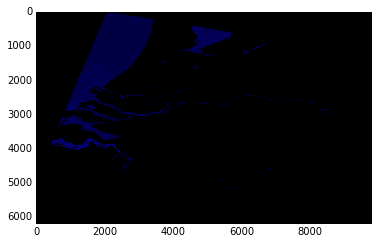

Removing temporary files 

Rperations done


In [60]:
#Dzjio Skripting
#Excercise 12
#Gersom Zomer & Yannick Mijnheer
#24 januari 2017

#import libaries
%matplotlib inline
import urllib2
import tarfile
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Float32
import numpy as np
import os
import matplotlib.pyplot as plt

#download files
url = "https://www.dropbox.com/s/zb7nrla6fqi1mq4/LC81980242014260-SC20150123044700.tar.gz?dl=1"

file_name = 'Temp/landsat.tar.gz'
u = urllib2.urlopen(url)
f = open(file_name, 'wb')
meta = u.info()
file_size = int(meta.getheaders("Content-Length")[0])
print "Downloading: %s Bytes: %s" % (file_name, file_size)
file_size_dl = 0
block_sz = 8192
while True:
    buffer = u.read(block_sz)
    if not buffer:
        break
        
    file_size_dl += len(buffer)
    f.write(buffer)
    status = r"%10d  [%3.2f%%]" % (file_size_dl, file_size_dl * 100. / file_size)
    status = status + chr(8)*(len(status)+1)
    print status,"\r",

print 'Download complete \n' 
f.close()

#unpack files
tar = tarfile.open("Temp/landsat.tar.gz")
tar.extractall("Temp")
tar.close

band4 = gdal.Open('Temp/LC81980242014260LGN00_sr_band4.tif', GA_ReadOnly)
band5 = gdal.Open('Temp/LC81980242014260LGN00_sr_band5.tif', GA_ReadOnly)

#Read data into an array
band4Arr = band4.ReadAsArray(0,0,band4.RasterXSize, band4.RasterYSize)
band5Arr = band5.ReadAsArray(0,0,band5.RasterXSize, band5.RasterYSize)
                                                 
# set the data type
band4Arr=band4Arr.astype(np.float32)
band5Arr=band5Arr.astype(np.float32)

#Derive the NDWI
mask = np.greater(band4Arr+band5Arr,0)

#set np.errstate to avoid warning of invalid values (i.e. NaN values) in the divide 
with np.errstate(invalid='ignore') and np.errstate(divide='ignore'):
    ndwi = np.choose(mask,(-99,(band4Arr-band5Arr)/(band4Arr+band5Arr)))

#Write the result to disk
print "Write result to disk \n"
driver = gdal.GetDriverByName('GTiff')
outDataSet=driver.Create('Temp/ndwi.tif', band4.RasterXSize, band4.RasterYSize, 1, GDT_Float32)
outBand = outDataSet.GetRasterBand(1)
outBand.WriteArray(ndwi,0,0)
outBand.SetNoDataValue(-99)

#set the projection and extent information of the dataset
outDataSet.SetProjection(band4.GetProjection())
outDataSet.SetGeoTransform(band4.GetGeoTransform())

#Saving the image
outBand.FlushCache()
outDataSet.FlushCache()

#reproject the image
print 'Reprojecting result to WGS84 latlong \n'
os.system('gdalwarp Temp/ndwi.tif Output/ndwi.tif -t_srs "EPSG:4326"')

# Open image
print 'Showing result \n'
dsll = gdal.Open("Output/ndwi.tif")

# Read raster data
ndwi = dsll.ReadAsArray(0, 0, dsll.RasterXSize, dsll.RasterYSize)

# Now plot the raster data using gist_earth palette
plt.imshow(ndwi, interpolation='nearest', vmin=0, cmap=plt.cm.gist_earth)
plt.show()

dsll = None

#removing temporary files
print 'Removing temporary files \n'
os.system('rm ~/jupyter/notebooks/GRS33806/Temp/*')
print 'Rperations done'